# Problem Description

## Kinematics

$ \dot{\eta} = f_\Omega(\eta) := -\Omega^\times \eta$

## Magnetometer Measurement Equation

$ y = h(\eta) = c_m \eta \in \mathbb{R}^3 $

# Equivariant Filter Design Preliminaries

## Step 1: Find a Lie Group $G$ and a state action $\phi : G \times \mathcal{M} \mapsto \mathcal{M}$

$\phi(R, \eta) := R^T \eta$

We show the state symmetry, by showing it is a right group action. Application of this action to a product of group elements is equivalent to sequential application to each element in the group.

$\phi(Y, \phi(X, \eta)) = Y^T X^T \eta = \phi(XY, \eta)$

## Step 2: Check that the System is Equivariant and Compute the Input Symmetry : $\psi : G \times \mathbb{L} \mapsto \mathbb{L}$

Define the input right group action as: 

$SO(3) \times \mathbb{R}^3 \mapsto \mathbb{R}^3$

$\psi(R, \Omega) := R^T \Omega$



The right group action used to describe the state symmetry, also induces a right group action on vector fields.

$\Phi(X, f) := D \phi_X \cdot f \circ \phi_X^{-1}$

We will use from above that:

$\phi_R(\eta) = R^T\eta$

$\phi_R^{-1}(\eta) = R\eta$

$f_\Omega(\eta) := -\Omega^\times \eta$

Substituting these functions in:

$\Phi(R, f_\Omega) = D \phi_R \cdot f_\Omega \circ \phi_R^{-1}$

$D \phi_R [v] = D_{\eta'} |_{v}  R^T\eta = \lim\limits_{t \rightarrow 0} \dfrac{R^T(\eta' + t v) - R^T(\eta')}{t} = R^T v$

$f_\Omega \circ \phi_R^{-1} = -\Omega^\times R \eta$

$\Phi(R, f_\Omega) (\eta) = - R^T \Omega^\times R \eta = - (R^T \Omega)^\times \eta = f_{\psi(R, \Omega)} (\eta)$

## Step 3: Construct an Equivariant Lift $\Lambda : \mathcal{M} \times \mathbb{L} \mapsto \mathfrak{g}$

$D_{X|id} \phi_\xi(X) [\Lambda(\xi, u)] = f_u(\xi)$

$D_{R|id} \phi_\eta(R)[v] = \lim\limits_{t \rightarrow 0} \dfrac{1}{2}$

In [1]:
import casadi as ca
import cyecca.lie as lie
from cyecca.util import rk4
from cyecca.symbolic import casadi_to_sympy
import numpy as np
import matplotlib.pyplot as plt

In [10]:
ca.DM([2, 4, 6]) ** 2

DM([4, 16, 36])

In [226]:
def derive_functions():
    u = ca.SX.sym("u", 3)
    x = ca.SX.sym("x", 3)
    p = ca.SX.sym("p", 0)

    x_h = ca.SX.sym("x_h", 3)
    x_e = ca.SX.sym("x_e", 3)
    t = ca.SX.sym("t")
    dt = ca.SX.sym("dt")
    cm = 1

    f_f = ca.Function(
        "f",
        [x, u, p, dt],
        [lie.SO3Dcm.exp(lie.so3.elem(-u * dt)).to_Matrix() @ x],
        ["x", "u", "p", "dt"],
        ["x1"],
    )

    f_h = ca.Function("h", [x, u, p], [x / ca.norm_2(x)], ["x", "u", "p"], ["h"])

    f_g = ca.Function("g", [x, u, p], [ca.dot(x, x)], ["x", "u", "p"], ["g"])

    return locals()


funcs = derive_functions()


def derive_ekf_predict(f):
    """
    x1 = f(x, u, p, dt)
    """
    dt = ca.SX.sym("dt")

    n = f.numel_in(0)  # number of states
    m = f.numel_in(1)  # number of inputs
    l = f.numel_in(2)  # number of parameters

    Q = ca.SX.sym("Q", n, n)
    M = ca.SX.sym("M", m, m)

    x = ca.SX.sym("x", n)
    u = ca.SX.sym("u", m)

    x_0 = ca.SX.sym("x_0", n)
    u_0 = ca.SX.sym("u_0", m)
    p_0 = ca.SX.sym("p_0", l)
    P_0 = ca.SX.sym("P_0", n, n)

    F = ca.sparsify(ca.jacobian(f(x, u_0, p_0, dt), x))
    F = ca.substitute(F, x, x_0)

    B = ca.jacobian(f(x_0, u, p_0, dt), u)
    B = ca.substitute(B, u, u_0)

    P_1 = ca.sparsify(F @ P_0 @ F.T + B @ M @ B.T + Q)
    x_1 = f(x_0, u_0, p_0, dt)
    return ca.Function(
        "predict",
        [x_0, u_0, p_0, P_0, Q, M, dt],
        [x_1, P_1],
        ["x_0", "u", "p", "P_0", "Q", "M", "dt"],
        ["x_1", "P_1"],
    )


f_ekf_predict = derive_ekf_predict(funcs["f_f"])

In [227]:
f_ekf_predict([1, 2, 3], [1, 2, 3], [], ca.SX.eye(3), ca.SX.eye(3), ca.SX.eye(3), 1)

(SX([1, 2, 3]),
 SX(@1=-0.521514, @2=-0.782271, @3=-1.56454, 
 [[5.38984, @1, @2], 
  [@1, 4.60757, @3], 
  [@2, @3, 3.30379]]))

In [228]:
def derive_ekf_correct(g):
    """
    y = g(x, u, p)
    """
    n = g.numel_in(0)  # number of states
    m = g.numel_in(1)  # number of inputs
    l = g.numel_in(2)  # number of parameters
    o = g.numel_out(0)  # number of outputs

    y = ca.SX.sym("y", o)
    R = ca.SX.sym("R", o, o)

    x = ca.SX.sym("x", n)
    u = ca.SX.sym("u", m)

    x_0 = ca.SX.sym("x_0", n)
    u_0 = ca.SX.sym("u_0", m)
    p = ca.SX.sym("p", l)
    P_0 = ca.SX.sym("P_0", n, n)

    H = ca.jacobian(g(x, u_0, p), x)
    H = ca.substitute(H, x, x_0)

    I = ca.SX.eye(n)
    S = H @ P_0 @ H.T + R
    S_I = ca.inv(S)
    K = P_0 @ H.T @ S_I
    P_1 = (I - K @ H) @ P_0
    y_h = g(x_0, u_0, p)
    x_1 = x_0 + K @ (y - y_h)
    return ca.Function(
        "predict",
        [x_0, u_0, p, y, P_0, R],
        [x_1, P_1],
        ["x_0", "u_0", "p", "y", "P_0", "R"],
        ["x_1", "P_1"],
    )


f_ekf_correct_h = derive_ekf_correct(funcs["f_h"])
f_ekf_correct_g = derive_ekf_correct(funcs["f_g"])

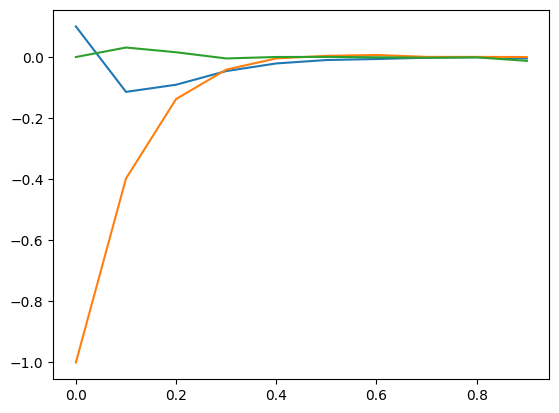

In [229]:
def simulate():
    dt = 0.1
    tf = 1
    hist = {
        "x": [],
        "x_h": [],
        "t": [],
        "P": [],
    }

    x = np.array([1, 0, 0])
    x_h = np.array([0.9, 1.0, 0])

    u = np.array([1, 2, 3])
    p = np.array([])

    P = 10 * np.eye(3)
    Q = 10 * np.eye(3)
    M = 10 * np.eye(3)
    R = 10 * np.eye(3)
    R_g = 0.1 * np.eye(1)

    for t in np.arange(0, tf, dt):
        # store
        hist["t"].append(t)
        hist["x"].append(np.array(ca.DM(x)).reshape(-1))
        hist["x_h"].append(np.array(ca.DM(x_h)).reshape(-1))
        hist["P"].append(np.array(ca.DM(P)).reshape(-1))

        # simulate
        x = funcs["f_f"](x, u, p, dt)
        y_h = funcs["f_h"](x, u, p) + 0.01 * np.random.randn(3)

        # filter
        x_h, P = f_ekf_predict(x_h, u, p, P, Q, M, dt)

        x_h, P = f_ekf_correct_h(x_h, u, p, y_h, P, R)

        g = funcs["f_g"](x_h, u, p)
        x_h, P = f_ekf_correct_g(x_h, u, p, 1, P, R_g)

    for k in hist.keys():
        hist[k] = np.array(hist[k])
    return hist


hist = simulate()
plt.plot(hist["t"], hist["x"] - hist["x_h"]);

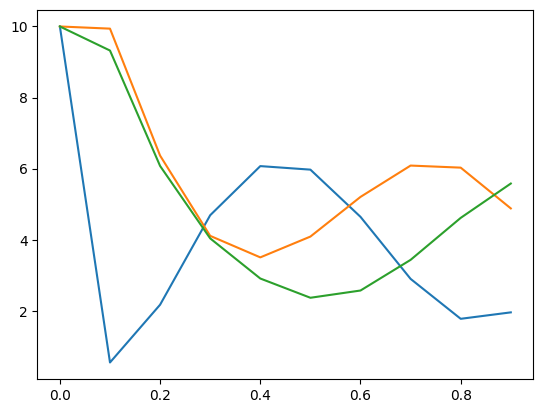

In [230]:
plt.plot(hist["t"], hist["P"][:, 0])
plt.plot(hist["t"], hist["P"][:, 4])
plt.plot(hist["t"], hist["P"][:, 8])